# Imports

In [79]:
import pandas as pd
from pandas_profiling import ProfileReport

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

import spacy

import seaborn as sns
import matplotlib.pyplot as plt     

In [2]:
filepath = '/home/yasin/AIDA/Twitter/twitter-disaster/raw/disaster_tweets.csv'

In [3]:
df_raw = pd.read_csv(filepath)

# Pandas Profiling

In [4]:
profile = ProfileReport(df_raw, title='Twitter Disaster', explorative=True)

In [5]:
# profile.to_file("your_report.html")

# Variables

In [6]:
df_raw.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

# Functions

In [95]:
def cm_viz(cm, name):
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, fmt='d'); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix: ' + name)
    plt.show();

# Split

In [7]:
X = df_raw.drop('target', axis=1)
y = df_raw['target']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42, stratify=y)

In [9]:
X_train.shape, y_train.shape

((5100, 4), (5100,))

In [10]:
# drop ids, unnecessary
X_train = X_train.drop('id', axis=1)

In [11]:
# string cleaning
X_train['text'] = X_train['text'].str.lower()

In [12]:
# a few rows have no keywords
X_train = X_train.dropna(subset=['keyword'])

In [13]:
y_train = y_train.loc[X_train.index]

In [14]:
X_train_dummies = pd.get_dummies(X_train['keyword'])

# ML

## Keyword-Model

In [26]:
clf_keyword = LogisticRegression()

In [30]:
cross_val_score(clf_keyword, X_train_dummies, y_train, cv=5, scoring='f1').mean()

0.667848311267514

In [48]:
y_pred_keyword = cross_val_predict(clf_keyword, X_train_dummies, y_train, cv=5)

In [96]:
cm = confusion_matrix(y_train, y_pred_keyword)

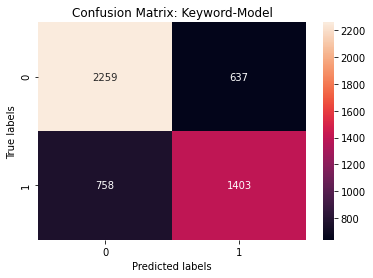

In [97]:
cm_viz(cm, 'Keyword-Model')

## TFIDF-Model

In [17]:
nlp = spacy.load("en_core_web_sm")

In [22]:
X_train['lemmatized'] = X_train['text'].apply(lambda text: " ".join([w.lemma_ for w in nlp(text)]))

In [24]:
vectorizer = TfidfVectorizer()

In [25]:
X_train_corpus = vectorizer.fit_transform(X_train['lemmatized'])

In [33]:
clf_corpus = LogisticRegression()

In [41]:
cross_val_score(clf_corpus, X_train_corpus, y_train, cv=5, scoring='f1').mean()

0.7319944137040271

In [47]:
y_pred_corpus = cross_val_predict(clf_corpus, X_train_corpus, y_train, cv=5)

In [98]:
cm = confusion_matrix(y_train, y_pred_corpus)

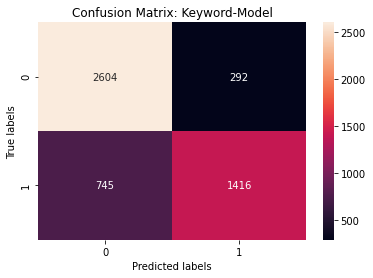

In [99]:
cm_viz(cm, 'Keyword-Model')

# Voting

In [60]:
df_stacking = pd.Series(y_pred_keyword).to_frame()
df_stacking.columns = ['pred_keyword']
df_stacking['corpus'] = y_pred_corpus

In [66]:
df_stacking

,pred_keyword,corpus
0,0,0
1,0,0
2,1,1
3,1,1
4,1,0
...,...,...
5052,1,0
5053,0,1
5054,0,1
5055,0,0


In [68]:
clf_stacking = RandomForestClassifier()

In [70]:
cross_val_score(clf_stacking, df_stacking, y_train, cv=5, scoring='f1').mean()

0.7319944137040271

In [72]:
df_stacking['target'] = y_train

Keyword bringt keinen Mehrhwert im Stacking.